In [1]:
# Set some environment variables
import os
gpu_num = 0 # GPU to be used. Use "" to use the CPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Suppress some TF warnings
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    os.system("pip install sionna")
    import sionna

# Configure GPU
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
import warnings
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# Fix the seed for reproducible results
tf.random.set_seed(42)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset, tr38901
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement

# For the implementation of the Keras models
from tensorflow.keras import Model
import scipy.special as sp

In [3]:
BATCH_SIZE = 100
NUM_UT = 1
NUM_BS = 1
NUM_UT_ANT = 1
NUM_BS_ANT = 1

NUM_STREAMS_PER_TX = NUM_UT_ANT

NUM_BITS_PER_SYMBOL =4
CODERATE = 1

# Number of coded bitsa
n = int(10000)
print(n)
# Number of information bits
k = int(n*CODERATE)
print(k)


RX_TX_ASSOCIATION = np.array([[1]])
STREAM_MANAGEMENT = sionna.mimo.StreamManagement(RX_TX_ASSOCIATION, NUM_STREAMS_PER_TX)

10000
10000


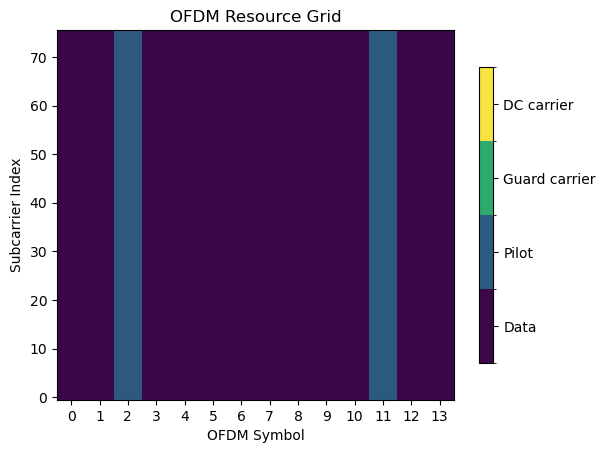

In [4]:
RESOURCE_GRID = sionna.ofdm.ResourceGrid( num_ofdm_symbols=14,
                                      fft_size=76,
                                      subcarrier_spacing=30e3,
                                      num_tx=NUM_UT,
                                      num_streams_per_tx=NUM_STREAMS_PER_TX,
                                      cyclic_prefix_length=6,
                                      pilot_pattern="kronecker",
                                      pilot_ofdm_symbol_indices=[2,11])
RESOURCE_GRID.show();

In [5]:
CARRIER_FREQUENCY = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

bs_array = tr38901.PanelArray(num_rows_per_panel = 1,
                      num_cols_per_panel = 1,
                      polarization = 'single',
                      polarization_type = 'V',
                      antenna_pattern = 'omni',
                      carrier_frequency = 3.5e9)

ut_array = tr38901.PanelArray(num_rows_per_panel = 1,
                      num_cols_per_panel = 1,
                      polarization = 'single',
                      polarization_type = 'V',
                      antenna_pattern = 'omni',
                      carrier_frequency = 3.5e9)

DELAY_SPREAD = 10e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value.

DIRECTION = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.

CDL_MODEL = "C"       # Suitable values are ["A", "B", "C", "D", "E"]

SPEED = 0         # UT speed [m/s]. BSs are always assumed to be fixed.
                     # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
CDL = sionna.channel.tr38901.CDL(CDL_MODEL,
                             DELAY_SPREAD,
                             CARRIER_FREQUENCY,
                             ut_array,
                             bs_array,
                             DIRECTION,
                             min_speed=SPEED)

In [ ]:
class OFDMSystem(Model): # Inherits from Keras Model

    def __init__(self):
        super().__init__() # Must call the Keras model initializer

        #self.perfect_csi = perfect_csi

        n = int(RESOURCE_GRID.num_data_symbols*NUM_BITS_PER_SYMBOL) # Number of coded bits
        k = int(n*CODERATE) # Number of information bits
        self.k = k
        
        print(n)
        print(k)

        # The binary source will create batches of information bits
        self.binary_source = sionna.utils.BinarySource()

        # The encoder maps information bits to coded bits
        #self.encoder = sionna.fec.ldpc.LDPC5GEncoder(k, n)

        # The mapper maps blocks of information bits to constellation symbols
        self.mapper = sionna.mapping.Mapper("qam", NUM_BITS_PER_SYMBOL)

        # The resource grid mapper maps symbols onto an OFDM resource grid
        self.rg_mapper = sionna.ofdm.ResourceGridMapper(RESOURCE_GRID)

        # Frequency domain channel
        self.channel = sionna.channel.OFDMChannel(CDL, RESOURCE_GRID, add_awgn=True, normalize_channel=True, return_channel=True)

        # The LS channel estimator will provide channel estimates and error variances
        self.ls_est = sionna.ofdm.LSChannelEstimator(RESOURCE_GRID, interpolation_type="nn")

        # The LMMSE equalizer will provide soft symbols together with noise variance estimates
        self.lmmse_equ = sionna.ofdm.LMMSEEqualizer(RESOURCE_GRID, STREAM_MANAGEMENT)

        # The demapper produces LLR for all coded bits
        self.demapper = sionna.mapping.Demapper("app", "qam", NUM_BITS_PER_SYMBOL, hard_out = True)

        # The decoder provides hard-decisions on the information bits
        #self.decoder = sionna.fec.ldpc.LDPC5GDecoder(self.encoder, hard_out=True)

    @tf.function # Graph execution to speed things up
    def __call__(self, batch_size, ebno_db):
        no = sionna.utils.ebnodb2no(ebno_db, num_bits_per_symbol=NUM_BITS_PER_SYMBOL, coderate=CODERATE, resource_grid=RESOURCE_GRID)

        # Transmitter
        bits = self.binary_source([batch_size, NUM_UT, RESOURCE_GRID.num_streams_per_tx, self.k])
        #codewords = self.encoder(bits)
        x = self.mapper(bits)
        x_rg = self.rg_mapper(x)

        # Channel
        y, h_freq = self.channel([x_rg, no])
        print(h_freq.shape)

        # Receiver
        h_hat, err_var = self.ls_est ([y, no])
        x_hat, no_eff = self.lmmse_equ([y, h_hat, err_var, no])
        bits_hat = self.demapper([x_hat, no_eff])
        #bits_hat = self.decoder(llr)

        return bits, bits_hat

In [ ]:
EBN0_DB_MIN = -3.0 # Minimum value of Eb/N0 [dB] for simulations
EBN0_DB_MAX = 20.0 # Maximum value of Eb/N0 [dB] for simulations

ber_plots = sionna.utils.PlotBER("OFDM over 3GPP CDL")

model_ls = OFDMSystem()
ber_plots.simulate(model_ls,
                  ebno_dbs = np.arange(EBN0_DB_MIN, EBN0_DB_MAX + 1, 1),
                  batch_size=BATCH_SIZE,
                  num_target_block_errors=10, # simulate until 100 block errors occured
                  legend="LS Estimation",
                  soft_estimates=True,
                  max_mc_iter=100, # run 100 Monte-Carlo simulations (each with batch_size samples)
                  show_fig=False);


ber_plots();